In [2]:
import os
import chardet
import binascii
import shutil
import numpy as np
import re
from subprocess import run
#
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
#
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
#
import scipy.stats as stats

In [3]:
PATH_TO_FILES = r'/Users/owl/Pycharm/PycharmProjects/KMZ/OTU/files/in/closed'
PATH_TO_SAVE_FILES = r'/Users/owl/Pycharm/PycharmProjects/KMZ/OTU/files/out/closed_by_shipr'
PATH_TO_RACKS_EXE = r'/Users/owl/Pycharm/PycharmProjects/KMZ/OTU/files/in/RAKCS.exe'

PATH_TO_TMP_FNAME = r'~temporary.file'

# PATH_TO_HEX = PATH_TO_SAVE_FILES + r'hex_files/'
PATH_TO_CSV = PATH_TO_SAVE_FILES + r'!Метаданные.tsv'
PATH_TO_IMG = PATH_TO_SAVE_FILES + r'Разбиение по источникам/'
PATH_TO_BAD = PATH_TO_SAVE_FILES + r'Без заголовка/'
PATH_TO_BIN = PATH_TO_SAVE_FILES + r'BIN данные/'

PATH_TO_CATERINE     = PATH_TO_SAVE_FILES + r'Катерина/'
PATH_TO_RSA          = PATH_TO_SAVE_FILES + r'RSA/'
PATH_TO_STB1         = PATH_TO_SAVE_FILES + r'STB1/'
PATH_TO_SUBSTITUTION = PATH_TO_SAVE_FILES + r'Подстановка/'
PATH_TO_SIMPLE_REPL  = PATH_TO_SAVE_FILES + r'Простая замена/'
PATH_TO_REKS         = PATH_TO_SAVE_FILES + r'РЕКС/'
PATH_TO_UGROZA       = PATH_TO_SAVE_FILES + r'Угроза НАТО/'
PATH_TO_CITADEL      = PATH_TO_SAVE_FILES + r'Цитадель/'
PATH_TO_OTHER        = PATH_TO_SAVE_FILES + r'Другие шифры/'
PATH_TO_CITADEL_CATERINE = PATH_TO_SAVE_FILES + r'Цитадель или Катерина/'
PATH_TO_WAV          = PATH_TO_SAVE_FILES + r'Аудио/'

BADLY = 0
HEX_DATA = list()
ENCODING = 'utf-16'

CH = [
    PATH_TO_IMG,
    PATH_TO_BAD,
    PATH_TO_BIN,

    PATH_TO_CATERINE,
    PATH_TO_RSA,
    PATH_TO_STB1,
    PATH_TO_SUBSTITUTION,
    PATH_TO_SIMPLE_REPL,
    PATH_TO_REKS,
    PATH_TO_UGROZA,
    PATH_TO_CITADEL,
    PATH_TO_OTHER,
    PATH_TO_CITADEL_CATERINE,
    PATH_TO_WAV,
]
for p_i in CH:
    try:
        os.makedirs(p_i)
    except FileExistsError:
        pass

if os.path.exists(PATH_TO_CSV):
    NEW_LINE = False
else:
    NEW_LINE = True

## Загрузка данных

In [4]:
def check_patch(patch_to_check):
    try:
        os.makedirs(patch_to_check)
    except FileExistsError:
        pass

In [5]:
def get_meta(text):
    text = text.replace('\n', '').split(';')
    my_dict = dict()
    for key_value in text:
        key_value = key_value.split(':')
        my_dict[key_value[0]] = key_value[1]
    return my_dict

In [7]:
def hex_strip(hex_string):
    return hex_string[4:] if hex_string.startswith("0d0a") else hex_string

In [8]:
def read_data_bin(fname, reusable=False, body=None):
    # print(fname)
    global BADLY, HEX_DATA
    if not reusable and body is not None:
        bin_file = body
    else:
        bin_file = open(fname, "rb").read()
    len_meta_data = len("".join([chr(i) for i in bin_file]).split("\n")[0].strip())
#     print(fname, bin_file)
    meta_data_raw = bin_file[0:len_meta_data]
    meta_encode = chardet.detect(meta_data_raw)['encoding']
    #print(chardet.detect(meta_data_raw))
    if chardet.detect(meta_data_raw)['confidence'] < 0.9:
        meta_encode = 'windows-1251'
    try:
        meta_data = meta_data_raw.decode(meta_encode)
    except UnicodeDecodeError:
        meta_data = "".join([chr(i) for i in meta_data_raw])
    # if chardet.detect(meta_data_raw)['encoding'] is None:
    #     # bin_file = binascii.unhexlify(bin_file)
    #     return -1, -1
    start_pos = len_meta_data
    while start_pos < len(bin_file) and chr(bin_file[start_pos]) in ('\n', '\r'):
        start_pos += 1
    bin_data = bin_file[start_pos:]
    hex_data = hex_strip(str(binascii.hexlify(bin_data)).strip("b'"))
    hex_symbols_data = np.array([int(x, 16) for x in re.findall(r'..', hex_data)])
    try:
        if "ktg" in meta_data:
            meta_data = get_meta(meta_data)
        else: 
            return None, bin_data, hex_data, hex_symbols_data
    except IndexError:
        #print(fname)
        HEX_DATA.append(fname)
        BADLY += 1
        return None, None, None, None
    return meta_data, bin_data, hex_data, hex_symbols_data

ktg_files = [file for file in os.listdir(PATH_TO_FILES) if '.ktg' in file and "1203145836_46999" in file]
cryptogramms_full = [read_data_bin(os.path.join(PATH_TO_FILES, file)) for file in ktg_files]
cryptogramms_headers = [x[0] for x in cryptogramms_full]
cryptogramms_binary = [x[1] for x in cryptogramms_full]
cryptogramms_hexbin = [x[2] for x in cryptogramms_full]
cryptogramms_hexsymb = [x[3] for x in cryptogramms_full]
cryptogramms_headers

[None]

In [9]:
ktg_files

['1203145836_46999.ktg']

In [10]:
ktg_files = [file for file in os.listdir(PATH_TO_FILES) if '.ktg' in file] #and "1203145836_47017.ktg" in file]
cryptogramms_full = [read_data_bin(os.path.join(PATH_TO_FILES, file)) for file in ktg_files]
cryptogramms_headers = [x[0] for x in cryptogramms_full]
cryptogramms_binary = [x[1] for x in cryptogramms_full]
cryptogramms_hexbin = [x[2] for x in cryptogramms_full]
cryptogramms_hexsymb = [x[3] for x in cryptogramms_full]
cryptogramms_headers

[None,
 None,
 {'Tmake': '03.12.2019 14',
  'from': 'Stiven',
  'ktg': '46896',
  'time': '11290200',
  'tlg': '1917',
  'to': 'Fred'},
 {'Tmake': '03.12.2019 14',
  'from': 'Admin@globus.com',
  'ktg': '46819',
  'time': '11271125',
  'tlg': '1591',
  'to': 'Faa85@globus.com'},
 {'Tmake': '03.12.2019 14',
  'from': 'Admin@globus.com',
  'ktg': '46841',
  'time': '11271135',
  'tlg': '1593',
  'to': 'kotov@phone.com'},
 {'Tmake': '03.12.2019 14',
  'from': 'r29701',
  'ktg': '47134',
  'time': '12011755',
  'tlg': '1242',
  'to': 'r30301'},
 None,
 {'Tmake': '03.12.2019 14',
  'from': 'bza',
  'ktg': '47209',
  'time': '12021000',
  'tlg': '2286',
  'to': 'fl'},
 None,
 {'Tmake': '03.12.2019 14',
  'from': 'pl',
  'ktg': '47221',
  'time': '12021024',
  'tlg': '2199',
  'to': 'bz'},
 None,
 None,
 {'Tmake': '03.12.2019 14',
  'from': 'Admin@globus.com',
  'ktg': '46869',
  'time': '11280926',
  'tlg': '1597',
  'to': 'Faa85@globus.com'},
 {'Tmake': '03.12.2019 14',
  'from': 'kotov@poc

In [11]:
a = cryptogramms_hexsymb[ktg_files.index("1204122218_47612.ktg")]
print(a)
ord("A"), ord("L")
(ord("A") <= a ) & (a  <= ord("L")) \
| (ord("N") == a )\
| (ord("X") == a )\
| (ord("Y") == a )\
| (ord("Z") == a )

[66 70 68 ... 79 80 77]


array([ True,  True,  True, ..., False, False, False])

In [12]:
def REKS_decryptor(bin_data):
    open(PATH_TO_TMP_FNAME, "wb").write(bin_data)
    return(run([PATH_TO_RACKS_EXE, PATH_TO_TMP_FNAME]).returncode)

In [13]:
stats.chi2_contingency(np.array([[10, 20, 30, 40], [100, 300, 200, 100]]))

(45.72073888844075,
 6.502338222270856e-10,
 3,
 array([[ 13.75,  40.  ,  28.75,  17.5 ],
        [ 96.25, 280.  , 201.25, 122.5 ]]))

In [14]:
def check_chi(hex_text, max_len=26):
    unique, counts = np.unique(hex_text, return_counts=True)
    text_freq = sorted(counts)
    ENG_CHARS_FREQUENCE = sorted(np.array([8.167, 1.492, 2.202, 4.253, 12.702, 2.228, 2.015, 6.094, 6.966, 0.153, 1.292, 4.025, 2.406, 6.749, 7.507, 1.929, 0.095, 5.987, 6.327, 9.356, 2.758, 0.978, 2.560, 0.150, 1.994, 0.077]) / 100 * np.sum(counts))
    comp_text_len = min(max_len, len(text_freq))
    if comp_text_len == 0:
        return None
    obs = np.array([text_freq[:comp_text_len], ENG_CHARS_FREQUENCE[:comp_text_len]])
    #print(obs.shape)
    chi2, p, dof, expected = stats.chi2_contingency(obs)
    return chi2, p

np.sum(np.array([check_chi(c)[1] for c in cryptogramms_hexsymb if c.any()]) > 0.05)

5

## Классификатор

In [15]:
def crypto_classifier(cryptogramm_header, cryptogramm_binary, cryptogramm_hexsym):
#     PATH_TO_CATERINE,
#     PATH_TO_RSA,
#     PATH_TO_STB1,
#     PATH_TO_SUBSTITUTION,
#     PATH_TO_SIMPLE_REPL,
#     PATH_TO_REKS,
#     PATH_TO_UGROZA,
#     PATH_TO_CITADEL,
#     PATH_TO_OTHER,
#     print(cryptogramm_header)
    if  cryptogramm_header:
        kate_bool = ((ord("A") <= cryptogramm_hexsym) & (cryptogramm_hexsym <= ord("P"))).all()
        citadel_bool = ((ord("A") <= cryptogramm_hexsym) & (cryptogramm_hexsym <= ord("L"))\
                        | (ord("N") == cryptogramm_hexsym)\
                        | (ord("X") == cryptogramm_hexsym)\
                        | (ord("Y") == cryptogramm_hexsym)\
                        | (ord("Z") == cryptogramm_hexsym)).all()
        if kate_bool and citadel_bool:
            # Citadel and caterine
            return PATH_TO_CITADEL_CATERINE, 'citadel_caterine'  
        if citadel_bool:
            # Citadel
            return PATH_TO_CITADEL, 'citadel'
        if kate_bool:
            # Kate
            return PATH_TO_CATERINE, 'caterine'
        text_bin = str(cryptogramm_binary)
        if "key" in text_bin:
            # RSA
            tmp = "".join([chr(i) for i in cryptogramm_binary]).split("Stop public key")[0]
            keys_header = cryptogramm_binary[:len(tmp.strip())].decode("utf-8")
            data = cryptogramm_binary[len(tmp) + len("Stop public key"):]
            
            return PATH_TO_RSA, 'RSA', data, list(map(
                lambda x: x.strip("\n\r "),
                keys_header
                .replace("Start key", "")
                .replace("Stop key", "\n")
                .replace("Start public key", "")
                .split("\n")))
        if "RIFF" in text_bin and "WAVE" in text_bin:
            return PATH_TO_WAV, "audio"
        if REKS_decryptor(cryptogramm_binary) == 0:
            return PATH_TO_REKS, 'reks'
        return PATH_TO_OTHER, 'unknown'
    else:
        text_bin = str(cryptogramm_binary)
    return PATH_TO_BAD, 'file without header'

for cryptogramm_header, cryptogramm_binary, cryptogramm_hexsym, fname in zip(
    cryptogramms_headers, cryptogramms_binary, cryptogramms_hexsymb, ktg_files):
    data = crypto_classifier(cryptogramm_header, cryptogramm_binary, cryptogramm_hexsym)
    if data[1] == "RSA":
        class_path, crypto_type, data, keys = data
        key, public_key_N, public_key_e = keys
        open(os.path.join(class_path, "RSA." + fname + ".txt"), "w").write(" ".join(keys))
        cryptogramm_binary = data
        output_fname = "e={}.{}".format(public_key_e, fname)
    else:
        output_fname = fname
        class_path, crypto_type = data
    # Ко всем бинарникам
    open(os.path.join(PATH_TO_BIN, output_fname), "wb").write(cryptogramm_binary)
    # Исходная криптограмма в класс
    shutil.copy(os.path.join(PATH_TO_FILES, fname), 
             os.path.join(class_path, output_fname))
    # Данные криптограммы в класс
    open(os.path.join(class_path, "BIN." + output_fname), "wb").write(cryptogramm_binary)
    print(crypto_type, class_path, output_fname)

file without header /Users/owl/Pycharm/PycharmProjects/KMZ/OTU/files/out/closed_by_shiprБез заголовка/ 1203145834_46882.ktg
file without header /Users/owl/Pycharm/PycharmProjects/KMZ/OTU/files/out/closed_by_shiprБез заголовка/ 1203145836_46989.ktg


OSError: [Errno 8] Exec format error: '/Users/owl/Pycharm/PycharmProjects/KMZ/OTU/files/in/RAKCS.exe'

## Препроцессинг

In [60]:
bigram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2), min_df=2)
X = bigram_vectorizer.fit_transform(cryptogramms)
#print(bigram_vectorizer.get_feature_names())
X = TfidfTransformer(use_idf=False).fit_transform(X)
visual_scale = TSNE()
visual_data = visual_scale.fit_transform(X.toarray())

## Визуализация

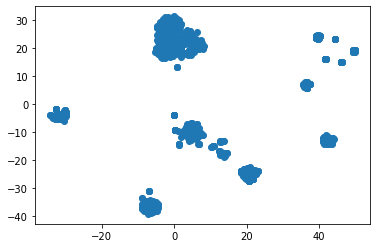

In [62]:
def show(clustering=None):
    plt.scatter(visual_data[:, 0], visual_data[:, 1], c=clustering, cmap=plt.cm.rainbow)
    plt.axis('tight')
show()

## Кластеризация

D:\programming\Anaconda3\lib\site-packages\sklearn\cluster\optics_.py:791: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


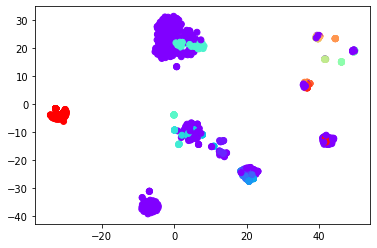

In [67]:
clustering = OPTICS(metric='cosine').fit(X_array).labels_
show(clustering)